In [4]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf

In [5]:
import pandas as pd

In [7]:
df = pd.read_csv("spam.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [13]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [25]:
df_ham = df[df['Category']=='ham']

In [26]:
df_spam = df[df['Category']=='spam']

In [27]:
df_ham.shape

(4825, 2)

In [28]:
df_ham = df_ham.sample(747)

In [29]:
df_ham.shape

(747, 2)

In [30]:
df_balanced = pd.concat([df_ham, df_spam])
df_balanced.shape

(1494, 2)

In [43]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.head(50)
df_balanced['spam'].value_counts()

0    747
1    747
Name: spam, dtype: int64

In [39]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [40]:
from sklearn.model_selection import train_test_split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'], stratify=df_balanced['spam'])

In [45]:
X_train.head(4)

2688                                         Okie
3331                  Send me yetty's number pls.
4074         Was the actual exam harder than NBME
4631    Everybody had fun this evening. Miss you.
Name: Message, dtype: object

In [49]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [50]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435169 , -0.5132726 , -0.888457  , ..., -0.7474884 ,
        -0.75314724,  0.91964495],
       [-0.8720836 , -0.50543964, -0.94446677, ..., -0.858475  ,
        -0.7174535 ,  0.8808298 ]], dtype=float32)>

In [51]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [52]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.99110883]], dtype=float32)

In [53]:
cosine_similarity([e[0]],[e[3]])


array([[0.84703845]], dtype=float32)

In [54]:
cosine_similarity([e[3]],[e[4]])


array([[0.9872036]], dtype=float32)

In [55]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [56]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [57]:
len(X_train)


1120

In [58]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [59]:
model.fit(X_train, y_train, epochs=10)


Epoch 1/10
35/35 [==============================] - 144s 4s/step - loss: 0.6337 - accuracy: 0.6661 - precision: 0.6582 - recall: 0.6911
Epoch 2/10
35/35 [==============================] - 139s 4s/step - loss: 0.4860 - accuracy: 0.8348 - precision: 0.8342 - recall: 0.8357
Epoch 3/10
35/35 [==============================] - 165s 5s/step - loss: 0.4101 - accuracy: 0.8786 - precision: 0.8643 - recall: 0.8982
Epoch 4/10
35/35 [==============================] - 209s 6s/step - loss: 0.3666 - accuracy: 0.8893 - precision: 0.8838 - recall: 0.8964
Epoch 5/10
35/35 [==============================] - 209s 6s/step - loss: 0.3484 - accuracy: 0.8830 - precision: 0.8667 - recall: 0.9054
Epoch 6/10
35/35 [==============================] - 182s 5s/step - loss: 0.3200 - accuracy: 0.9018 - precision: 0.8906 - recall: 0.9161
Epoch 7/10
35/35 [==============================] - 179s 5s/step - loss: 0.3068 - accuracy: 0.9054 - precision: 0.8955 - recall: 0.9179
Epoch 8/10
35/35 [==============================

In [60]:
model.evaluate(X_test, y_test)
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 61s 5s/step


In [61]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,

In [62]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[169,  18],
       [ 28, 159]])

Text(33.0, 0.5, 'Truth')

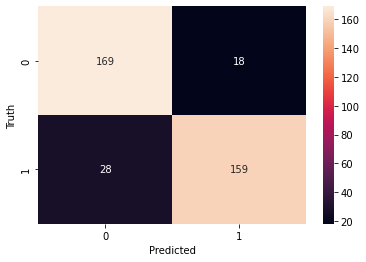

In [63]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [64]:
print(classification_report(y_test, y_predicted))


              precision    recall  f1-score   support

           0       0.86      0.90      0.88       187
           1       0.90      0.85      0.87       187

    accuracy                           0.88       374
   macro avg       0.88      0.88      0.88       374
weighted avg       0.88      0.88      0.88       374



In [65]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 2s 2s/step


array([[0.66088885],
       [0.7640429 ],
       [0.7045739 ],
       [0.16255684],
       [0.06253824]], dtype=float32)